# Age Prediction

In [16]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import sys

project_root = os.path.abspath(os.path.join(os.getcwd()))
sys.path.append(project_root)

from age.src.models.baseline import Baseline
from age.src.models.resnet_age import ResNetAge
from age.src.models.cbam import ResNetAgeWithCBAM  
from age.scripts.utils import get_device

In [17]:
class TestImageDataset(Dataset):
    def __init__(self, image_dir, csv_path, transform=None):
        self.image_dir = image_dir
        self.data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_id = row['image_id']
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image_id, image

In [18]:
config = {
    'test': {
        'test_dir': 'age/data/test_images',
        'prediction_csv_path': 'prediction_submission.csv',
        'test_batch_size': 64,
        'test_image_size': 224,
        'test_model_path': 'age/checkpoints/cbam34_model/best_model.pt',
        'model': 'cbam'  # options: 'baseline', 'resnet', 'cbam'
    }
}

AGE_MIN = 45.0
AGE_MAX = 82.0

In [19]:
transform = transforms.Compose([
    transforms.Resize((config['test']['test_image_size'], config['test']['test_image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
test_dataset = TestImageDataset(
    image_dir=config['test']['test_dir'],
    csv_path=config['test']['prediction_csv_path'],
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=config['test']['test_batch_size'], shuffle=False)

In [21]:
model_map = {
    "baseline": Baseline,
    "resnet": ResNetAge,
    "cbam": ResNetAgeWithCBAM
}

model_class = model_map.get(config['test']['model'], ResNetAge)
model = model_class()
model.load_state_dict(torch.load(config['test']['test_model_path'], map_location="cpu"))

device = get_device(force_cpu=False)
model.to(device)
model.eval()

[INFO] Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


ResNetAgeWithCBAM(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [23]:
predictions = []

with torch.no_grad():
    for image_ids, images in test_loader:
        images = images.to(device)
        outputs = model(images).view(-1)
        ages = outputs * (AGE_MAX - AGE_MIN) + AGE_MIN
        for img_id, age in zip(image_ids, ages):
            predictions.append((img_id, round(age.item(), 2)))

In [24]:
df = pd.read_csv(config['test']['prediction_csv_path'])
pred_dict = {img_id: age for img_id, age in predictions}
df['age'] = df['image_id'].map(pred_dict)
df.to_csv(config['test']['prediction_csv_path'], index=False)
print(f"[✓] Predictions saved to {config['test']['prediction_csv_path']}")

[✓] Predictions saved to prediction_submission.csv


Text(0, 0.5, 'Frequency')

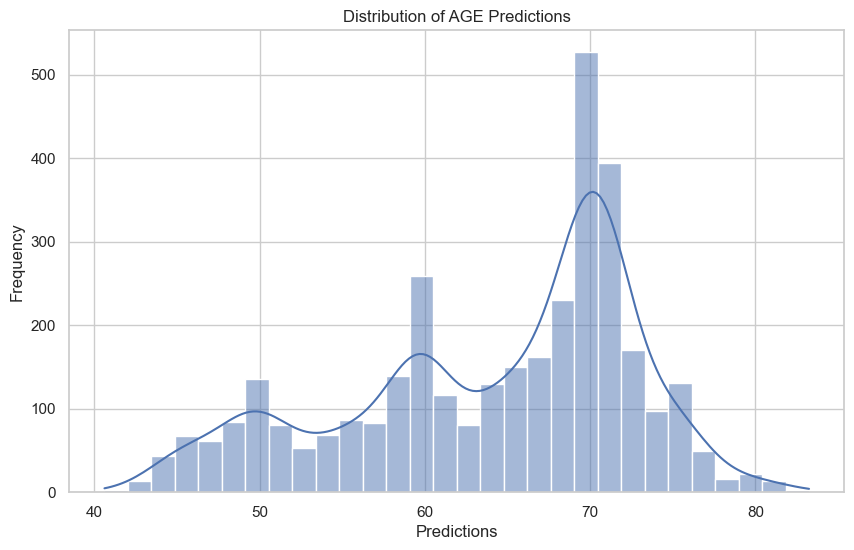

In [26]:
df = pd.read_csv('prediction_submission.csv')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribution of AGE Predictions')
plt.xlabel('Predictions')
plt.ylabel('Frequency')

# Disease

In [4]:
df = pd.read_csv('age\data\meta_train.csv')

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\User\AppData\Local\Temp\ipykernel_19708\2699853000.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('age\data\meta_train.csv')


In [ ]:
# plot the distribution of the disease


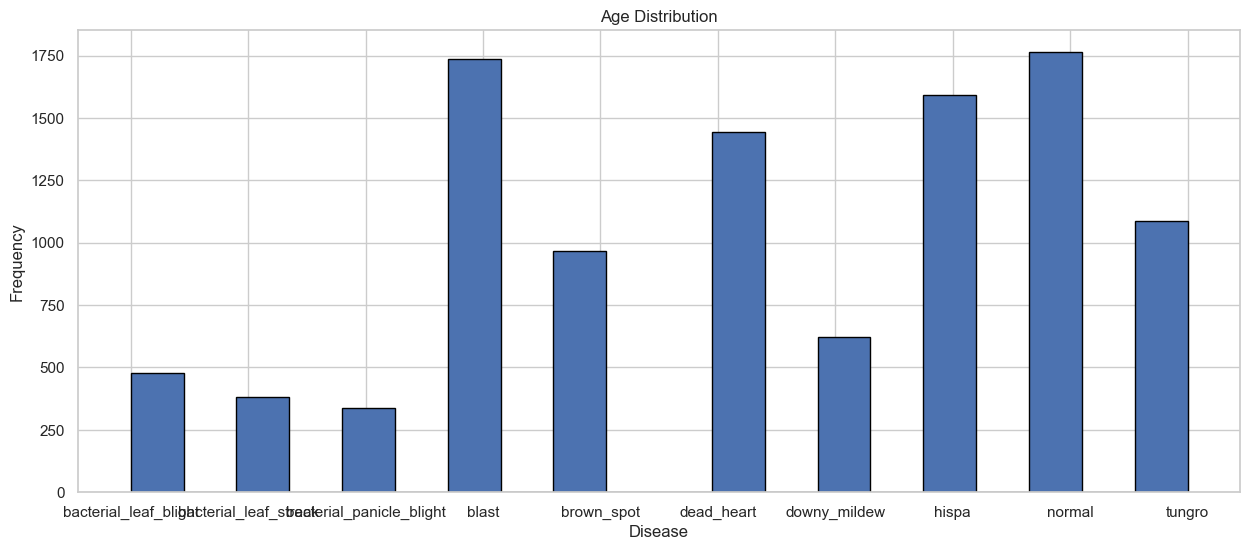

In [12]:
# plot the distribution of the disease
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))
plt.hist(df['label'], bins=20, edgecolor='black')
plt.xlabel('Disease')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()